<a href="https://colab.research.google.com/github/XtremeGood/Modsim/blob/main/Modsim_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U plotly

     |████████████████████████████████| 13.2MB 249kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


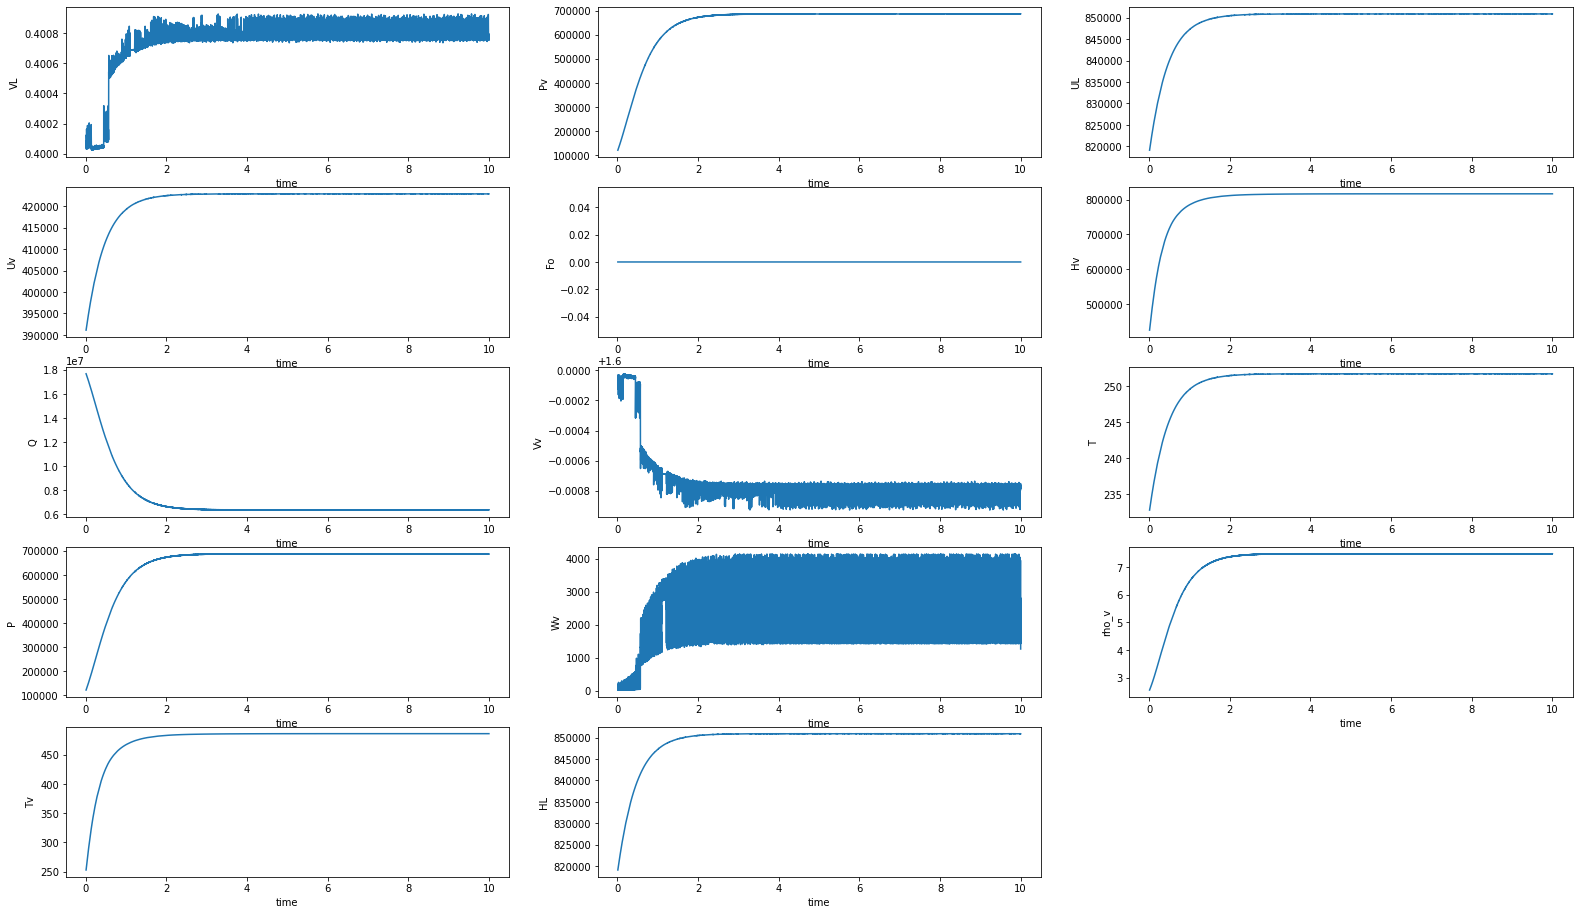

In [2]:
from random import random
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import RK45
from dataclasses import dataclass, InitVar, field, fields, asdict
from scipy.integrate import quad
from numpy.polynomial import polynomial as P
from scipy import integrate
from abc import abstractmethod, ABC
pd.options.plotting.backend = "plotly"
# All values are put in SI units

class Action(ABC):
  
    def __init__(self, prop_const, delay_time=0 ):
      self.K = prop_const
      self.delay_time = delay_time
    
    def wrapper_delay_time(self):
        def inner(self, *args, **kwargs):
          if self.delay_time<kwargs["times"][-1]:
            return f(*args, **kwargs)
          else:
            return 0 
        return inner    

     
    @abstractmethod
    @wrapper_delay_time 
    def take_action(self, errors, times):
      pass

class PAction(Action): 
   
   def take_action(self, errors, times):
        return self.K * errors[-1]
        
class IAction(Action) :
   def take_action(self, errors, times):
        return self.K* integrate.simps(errors, times )
   
class DAction(Action):
   def take_action(self, errors, times):  
        return self.K* np.gradient(errors, times)[-1] if (len(errors)>3  and len(times) >3) else 0 


class Controller:
  errors = []
  times = []
 
  def __init__(self,set_point, actions):
    
    self.set_point = set_point
    assert bool(actions)==True , "Atleast one action is required"    
    self.actions = actions
  
  def set_errors(self, error):
     self.errors.append(error)

  def set_times(self, time):
     self.times.append(time)

  def get_response(self, current_time, current_val):
     self.set_times(current_time)
     self.set_errors(self.set_point - current_val )
     
     total_action = 0
     for action in self.actions:
       total_action = action.take_action(self.errors, self.times)
     return total_action  


@dataclass
class InstantaneousData():
    y: InitVar[np.ndarray]
    t: InitVar[float]

    # liquid
    VL: float = field(init=False)
    Fo: float = field(init=False)
    T: float = field(init=False)
    P: float = field(init=False)
    HL: float = field(init=False)
    UL: float = field(init=False)
    Uv: float = field(init=False)

    # vapour
    Vv: float = field(init=False)
    rho_v: float = field(init=False)
    Tv: float = field(init=False)
    Pv: float = field(init=False)
    Hv: float = field(init=False)

    # others
    Q: float = field(init=False)
    Wv: float = field(init=False)

    def __post_init__(self, t, y):
        # liquid
        
        self.time = t
        self.VL = y[0] / rho_o
        temp = Fo_steady + functions["devFo"](t=t, VL=self.VL)
        self.Fo = temp if temp >= 0 else 0
        self.T = y[1] / (self.VL * Cp * rho_o)
        self.P = functions["P"](T=self.T)
        self.HL = functions["HL"](T=self.T)
        self.UL = functions["HL"](T=self.T)
        self.Uv = functions["Uv"](T=self.T)

        # vapour
        self.Vv = V_chamber - self.VL
        self.rho_v = y[2] / self.Vv
        self.Tv = y[3] / (self.Vv * self.rho_v * Cp)
        self.Pv = functions["Pv"](rho_v=self.rho_v, T=self.Tv)
        self.Hv = Cp * self.Tv

        # others
        temp = Qo_steady + functions["devQ"](t=t, P=self.P)
        self.Q = temp if temp >= 0 else 0
        self.Wv = functions["Wv"](P=self.P, Pv=self.Pv)


def derivative(t, y):
    assert y.ndim == 1, "Dimension is %s" % y.ndim
    data = InstantaneousData(t, y)

    return np.array(
        [
            rho_o * data.Fo - data.Wv,
            rho_o
            * data.Fo
            * ho
            - data.Wv * data.HL
            + data.Q,
            data.Wv - data.rho_v * Fv,
            data.Wv * data.HL
            - data.rho_v * Fv * data.Hv,
        ]
    )



# functions
functions = {
    "P": lambda T: 10 ** (A - B / (T + C)) * 100000,
    "Wv": lambda P, Pv: Km * (P - Pv),
    "Pv": lambda rho_v, T: (rho_v * R * T) / M,
    "devQ": lambda t, P: pressure_controller.get_response(t, P),
    "devFo": lambda t, VL: level_controller.get_response(t, VL),
    "HL": lambda T: latent_heat + T * Cp,
    "UL": lambda T: T * Cp,
    "Uv": lambda T: T * Cp,
}


###################################################
###################################################
###################################################

#controllers
level_controller = Controller(set_point=0.4, actions=(PAction(prop_const=2500000),) )
pressure_controller = Controller(set_point=1000 * 1000,actions=(PAction(prop_const=20),) )


# RK 45 parameters
t_bound = 10


# thermodynamic constants
R = 8.314  # J⋅ /K⋅ /mol

# Chamber properties
V_chamber = 2  # m^3

# Compound properties
Cp = 1.68 * 1000  # J / kg  / K
M = 44.1 / 1000  # kg / mol
Km = 1.71  # mol / s / Pa
latent_heat = 428 * 1000  # J / kg

# Antoine Equation
# Source: http://webserver.dmt.upm.es/~isidoro/dat1/ePv.pdf
A = 9.10
B = 1872  # K
C = -25.16  # K

# Inlet
rho_o = 493  # kg / m^ 3
To = 233.15  # K
ho = Cp * To

# Outlet
Fv = 2  # m^3/s

# Steady state values
Qo_steady = 100990  # J
Fo_steady = 2.11111  # m^3/s


# t  = 0 , intial values of variables
VL = 0.2 * V_chamber  # m^3
Vv = V_chamber - VL
rho_v = 2.356  # kg / m^3  https://www.engineeringtoolbox.com/propane-C3H8-density-specific-weight-temperature-pressure-d_2033.html
rho_o_VL = rho_o * VL
rho_VL_Cp_T = rho_o * VL * Cp * To
Vv_rho_v = Vv * rho_v
rho_v_Vv_Cp_T = rho_v * Vv * Cp * To


#############
def fill_dataframe(output):
    while output.status == "running":
        for i in range(50):
            if output.status == "running":
                output.step()
            else:
                break
        temp = {
            "time": output.t,
            **asdict(InstantaneousData(output.t, output.y)),

        }

        yield temp


output = RK45(
    fun=derivative,
    t0=0.01,
    y0=np.array([rho_o_VL, rho_VL_Cp_T, Vv_rho_v, rho_v_Vv_Cp_T]),
    t_bound=t_bound,
)

df = pd.DataFrame(data=[*fill_dataframe(output)])

ncols = 3
nrows = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(27, 16))

for i, v in enumerate(list(df.columns)[1:]):
    ax[i % nrows, i % ncols].plot(df["time"], df[v])
    ax[i % nrows, i % ncols].set_xlabel("time")
    ax[i % nrows, i % ncols].set_ylabel(v)
fig.delaxes(ax[nrows - 1][ncols - 1])
##plt.savefig(fr'imgs\{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')